# Time Series prediction with RNN

This notebook uses data from temperature sensor taken every 10 minutes and uses it to predict temperature for the next 24h.

The data can be download with the command
```sh
wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
```

In [15]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 4

import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

# Load data

After loading the data we will skip first column with DateTime and convert rest to numpy array

In [3]:
input_data = pd.read_csv('../../datasets/public/jena_climate_2009_2016.csv')
input_data = input_data.values[:, 1:].astype(float)
print(input_data)

[[ 9.9652e+02 -8.0200e+00  2.6540e+02 ...  1.0300e+00  1.7500e+00
   1.5230e+02]
 [ 9.9657e+02 -8.4100e+00  2.6501e+02 ...  7.2000e-01  1.5000e+00
   1.3610e+02]
 [ 9.9653e+02 -8.5100e+00  2.6491e+02 ...  1.9000e-01  6.3000e-01
   1.7160e+02]
 ...
 [ 9.9982e+02 -3.1600e+00  2.7001e+02 ...  1.0800e+00  2.0000e+00
   2.1520e+02]
 [ 9.9981e+02 -4.2300e+00  2.6894e+02 ...  1.4900e+00  2.1600e+00
   2.2580e+02]
 [ 9.9982e+02 -4.8200e+00  2.6836e+02 ...  1.2300e+00  1.9600e+00
   1.8490e+02]]


## Let's plot our temperature data

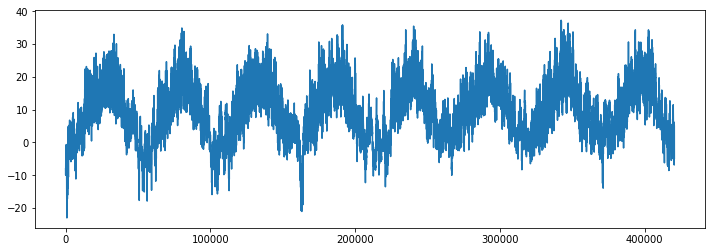

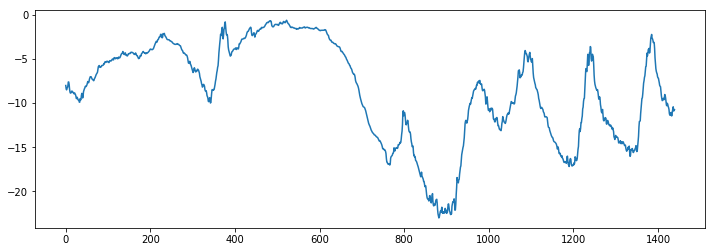

In [4]:
temperature = input_data[:, 1]
plt.plot(temperature)
plt.show()
# First 10 days
plt.plot(temperature[:1440])
plt.show()

# Preparing the data

## Normalize data

Since we have different time series, we need to normalize them so they will have similar scale

In [6]:
TRAINING_SIZE = 200000
mean = input_data[:TRAINING_SIZE].mean(axis=0)
stddev = input_data[:TRAINING_SIZE].std(axis=0)
normalized_data = (input_data - mean) / stddev
print(normalized_data)

[[ 0.90014748 -1.93135845 -1.98211036 ... -0.72950452 -0.78067973
  -0.27613603]
 [ 0.9060434  -1.97541381 -2.02567    ... -0.93124017 -0.88794488
  -0.46317443]
 [ 0.90132666 -1.98671006 -2.03683914 ... -1.27614304 -1.26122763
  -0.05330633]
 ...
 [ 1.28927851 -1.38236094 -1.46721307 ... -0.69696652 -0.67341457
   0.45008097]
 [ 1.28809932 -1.50323076 -1.58672285 ... -0.43015486 -0.60476487
   0.57246412]
 [ 1.28927851 -1.56987861 -1.65150386 ... -0.5993525  -0.690577
   0.10024989]]


## Data generator

Because the samples in the dataset are highly reduntant, we will use dataset generator for splitting data into separate train, test and validation set.

In [34]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    """
    Params:
    data - normalized input data
    lookback - how many timesteps back the input data should go
    delay - How many timesteps in the future the target should be
    min_index, max_index - data indices
    shuffle - randomize data?
    batch_size - #samples in the batch
    step - The period of data sampling (6 = every hour)
    """
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index+lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i+batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows), ))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

next(generator(normalized_data, 2, 0, 0, 10, shuffle=False, batch_size=1, step=1))

(array([[[ 0.90014748, -1.93135845, -1.98211036, -1.86280029,
           1.07285236, -1.30742164, -1.47375773, -0.79868641,
          -1.4762674 , -1.47815522,  2.12375056, -0.72950452,
          -0.78067973, -0.27613603],
         [ 0.9060434 , -1.97541381, -2.02567   , -1.91582958,
           1.07883061, -1.32042698, -1.4951961 , -0.80075238,
          -1.49502455, -1.49932141,  2.17199852, -0.93124017,
          -0.88794488, -0.46317443]]]), array([-1.98671006]))

In [35]:
lookback = 1440  # Use data from the last 10 days
step = 6         # Observations will be sampled at one data point per hour
delay = 144      # Targets will be 24 hours in the future
batch_size = 128 

train_gen = generator(normalized_data, lookback=lookback, delay=delay, min_index=0, max_index=TRAINING_SIZE, 
                      shuffle=True, batch_size=batch_size, step=step)

val_gen = generator(normalized_data, lookback=lookback, delay=delay, min_index=TRAINING_SIZE, max_index=300000, 
                    shuffle=True, batch_size=batch_size, step=step)

test_gen = generator(normalized_data, lookback=lookback, delay=delay, min_index=300001, max_index=None,
                     shuffle=True, batch_size=batch_size, step=step)

val_steps = 300000 - 200001 - lookback
test_steps = len(normalized_data) - 300001 - lookback

# Common-sense baseline

Based on intuition we will predict that that the temperature will be the same like in the last somple in feature vector.

In [21]:
def evaluate_naive_method():
    batch_meas = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:,-1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_meas.append(mae)
    print(np.mean(batch_meas))
    
start_time = time.time()    
evaluate_naive_method()    
print("Calculated in {:.3f} seconds".format(time.time() - start_time))

0.2894698975698747
Calculated in 560.915 seconds


# Basic ML model

Before starting using RNN, lets build model using small densely connected networks.
For this will will flat our 
```
(batch_size, lookback // step, #features)
```
tensor into
```
(batch_size, lookback // step * #features)
```

In [43]:
start_time = time.time()
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, normalized_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, 
                              validation_data=val_gen, validation_steps=1000)
print("Calculated in {:.3f} seconds".format(time.time() - start_time))

Epoch 1/20
500/500 [==============================] - 41s 82ms/step - loss: 1.5397 - val_loss: 1.0456
Epoch 2/20
500/500 [==============================] - 39s 79ms/step - loss: 0.6327 - val_loss: 0.5374
Epoch 3/20
500/500 [==============================] - 41s 81ms/step - loss: 0.4296 - val_loss: 0.3058
Epoch 4/20
500/500 [==============================] - 42s 85ms/step - loss: 0.2981 - val_loss: 0.3826
Epoch 5/20
500/500 [==============================] - 40s 80ms/step - loss: 0.4949 - val_loss: 0.3593
Epoch 6/20
500/500 [==============================] - 40s 80ms/step - loss: 0.3208 - val_loss: 0.7533
Epoch 7/20
500/500 [==============================] - 44s 88ms/step - loss: 0.3142 - val_loss: 0.3376
Epoch 8/20
500/500 [==============================] - 41s 82ms/step - loss: 0.2942 - val_loss: 0.3216
Epoch 9/20
500/500 [==============================] - 44s 87ms/step - loss: 0.2543 - val_loss: 0.3115
Epoch 10/20
500/500 [==============================] - 44s 88ms/step - loss: 0.241

## Plotting results

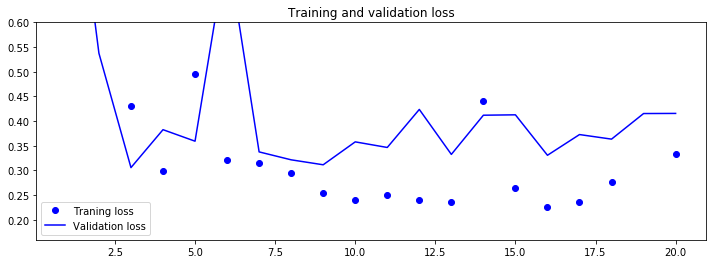

In [47]:
def plot_loss(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Traning loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.ylim(ymax=0.6)
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
    
plot_loss(history)

# RNN baseline

Lets now try RNN which should be more suited to this problem. 
For this network we will use GRU layers which are cheaper to compute then more powerful LSTM

In [ ]:
start_time = time.time()
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, normalized_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, 
                              validation_data=val_gen, validation_steps=1000)
print("Calculated in {:.3f} seconds".format(time.time() - start_time))

Epoch 1/20
500/500 [==============================] - 303s 606ms/step - loss: 0.2995 - val_loss: 0.2741
Epoch 2/20
500/500 [==============================] - 344s 689ms/step - loss: 0.2872 - val_loss: 0.2667
Epoch 3/20
500/500 [==============================] - 366s 731ms/step - loss: 0.2790 - val_loss: 0.2654
Epoch 4/20
500/500 [==============================] - 383s 766ms/step - loss: 0.2724 - val_loss: 0.2639
Epoch 5/20
500/500 [==============================] - 426s 852ms/step - loss: 0.2692 - val_loss: 0.2630
Epoch 6/20
374/500 [=====================>........] - ETA: 59s - loss: 0.2651 